In [1]:
#import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

from modules.midiscoretools import midi_to_bitmap, loadBitmap

In [2]:
def midi_to_note_name(midi_note):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = midi_note // 12 - 1
    return f"{note_names[midi_note % 12]}{octave}"

 ev.data is  b'\t\x89h'
 mspq will be set to 625000
 mspq is 625000
track_index = 0
track_index = 1
(5195, 128)


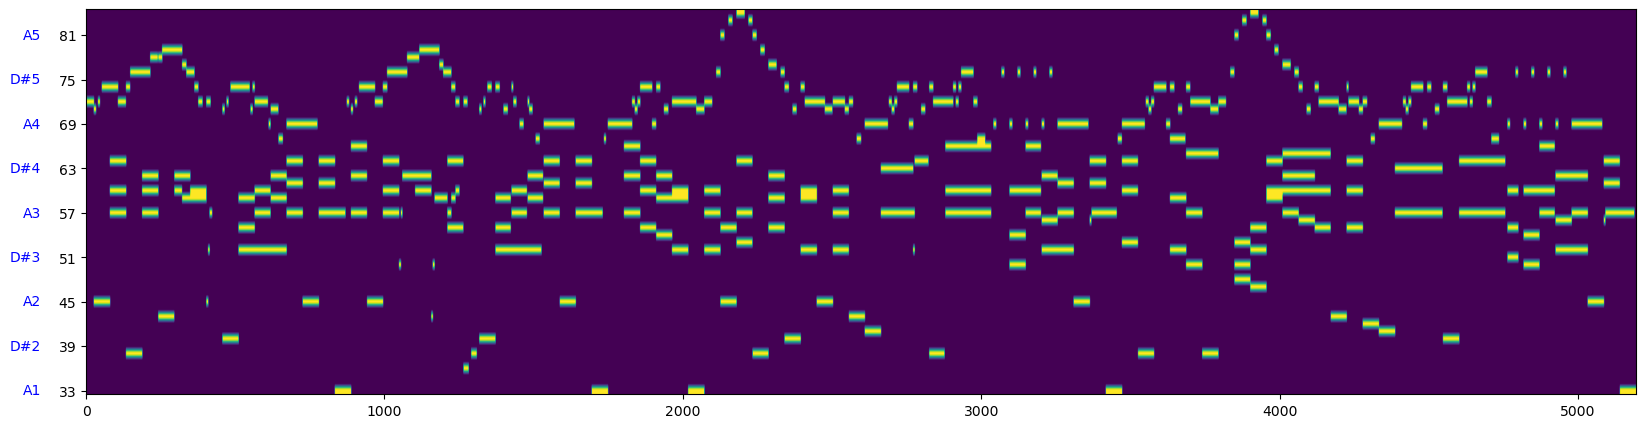

In [3]:
# Let's visualize (and create matrices for our data) 
#     from A0 (note number 21) to C7 (note number 96) 

midi_file = "scores/BartokRFD1/REFdata/BartokRFD1.mid"
#midi_file = "scores/Test3/RefData/Test3.mid"
fps=44100/512 # fps for our mel spectrogram

frames, minp, maxp = midi_to_bitmap(midi_file, fps) #same fps as our mel spectrogram
plt.figure(figsize=(20, 5))

# generate smaller matrix with rows only for notes that are used
#subset_matrix=frames.swapaxes(1,0)[minp:maxp+1, :]
subset_matrix=frames[minp:maxp+1, :]
plt.imshow(subset_matrix,  origin='lower', aspect='auto')

# Manually set the y-axis ticks and labels to be midi note numbers
yticks = np.arange(0, subset_matrix.shape[0], 6)  # Positions of ticks in the subset matrix
ytick_labels = np.arange(minp,maxp+1, 6)  # Original indices from the full matrix
plt.yticks(yticks, ytick_labels)

# Add text labels for note names next to each tick
for i, label in enumerate(ytick_labels):
    plt.text(-150, yticks[i], f'{midi_to_note_name(ytick_labels[i])}', va='center', ha='right', color='blue') 
plt.show()

In [4]:
frames.shape

(128, 5195)

In [5]:
def getlowhimidinotes(matrix) :# Find rows that contain at least one '1'
    rows_with_ones = np.any(matrix == 1, axis=1)

    # Get the lowest row index with a '1'
    lowest_row_index = np.argmax(rows_with_ones)

    # Get the highest row index with a '1'
    # Use len(matrix) - 1 - argmax of the reversed array to get the last '1'
    highest_row_index = len(rows_with_ones) - 1 - np.argmax(rows_with_ones[::-1])

    return lowest_row_index, highest_row_index


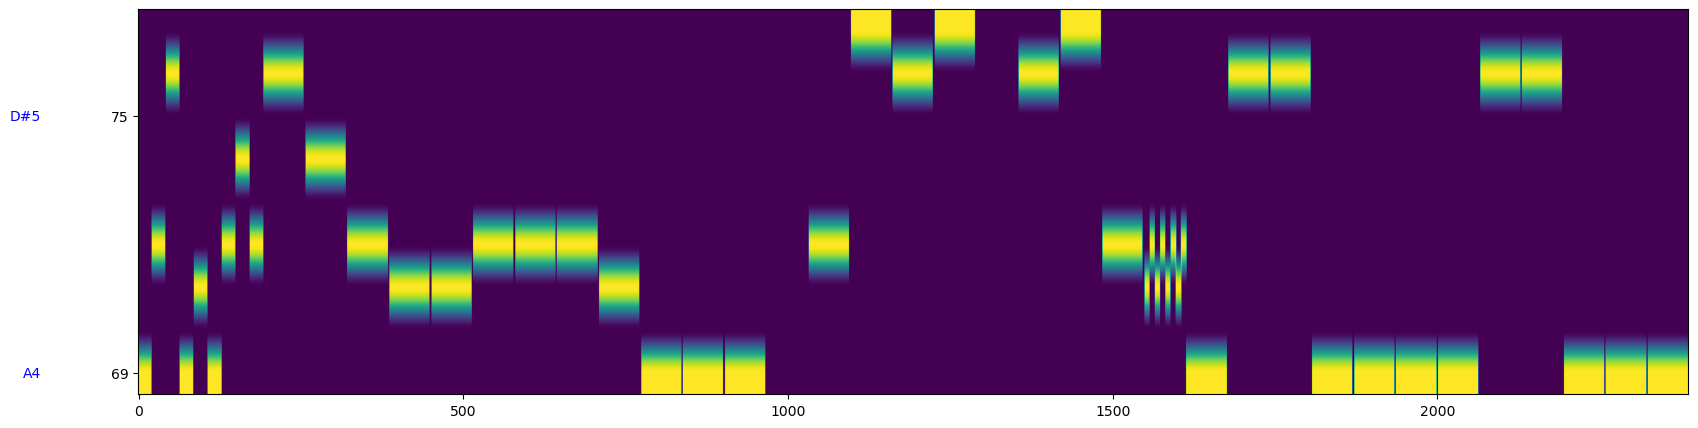

In [6]:
#try reading in a stored bitmap instead of creating it with pitch_to_frame
bmframes=loadBitmap('scores/Test3/RefData/Test3.bitmap.npz')
minp, maxp = getlowhimidinotes(bmframes)

plt.figure(figsize=(20, 5))

# generate smaller matrix with rows only for notes that are used
#subset_matrix=frames.swapaxes(1,0)[minp:maxp+1, :]
subset_matrix=bmframes[minp:maxp+1, :]
plt.imshow(subset_matrix,  origin='lower', aspect='auto')

# Manually set the y-axis ticks and labels to be midi note numbers
yticks = np.arange(0, subset_matrix.shape[0], 6)  # Positions of ticks in the subset matrix
ytick_labels = np.arange(minp,maxp+1, 6)  # Original indices from the full matrix
plt.yticks(yticks, ytick_labels)

# Add text labels for note names next to each tick
for i, label in enumerate(ytick_labels):
    plt.text(-150, yticks[i], f'{midi_to_note_name(ytick_labels[i])}', va='center', ha='right', color='blue') 
plt.show()